<a href="https://colab.research.google.com/github/Tomokki/private_Python-.gitkeep/blob/main/%E3%83%AC%E3%82%AF%E3%83%81%E3%83%A3%E3%83%BC4_%E3%83%99%E3%83%BC%E3%82%B9%E3%83%A9%E3%82%A4%E3%83%B3%E3%83%A2%E3%83%87%E3%83%AB%EF%BC%88%E7%B7%9A%E5%BD%A2%E5%9B%9E%E5%B8%B0%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2 ベースラインモデル構築
特徴量の追加など、予測精度向上の工夫を入れる前の状態でモデルの学習を行い提出までを行います  
線形回帰モデルの予測精度を算出し特徴量の重要度の可視化を行います  

In [ ]:
# ライブラリのインポートと表示の設定

import os
import gc
import time
import json
import random
import numpy as np
import pandas as pd
import lightgbm as lgb
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import seaborn as sns

### 日本語表示の設定
from matplotlib import rcParams
igfont = {'family':'IPAexGothic'}
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

In [ ]:
# 読み込むデータのパスをセット
'''
01_EDA_preprocessで作成したcsvのパスをsettings.jsonに設定し、それを読み込みます
'''

with open("../env_settings/settings.json") as f:
    path_file=json.load(f)

TRAIN_PROCESSED_DATA_PATH = path_file["TRAIN_PROCESSED_DATA_PATH"]
TEST_PROCESSED_DATA_PATH = path_file["TEST_PROCESSED_DATA_PATH"]

PROCESSED_DATA_DIR = path_file["PROCESSED_DATA_DIR"]
SUBMISSION_DIR = path_file["SUBMISSION_DIR"]

OUTPUT_DIR = path_file["OUTPUT_DIR"]

In [ ]:
#対象変数名
TARGET_COL="取引価格（総額）_log"
ID_COL="ID"
RANDOM_STATE=42

In [ ]:
#乱数設定
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"]=str(seed)


In [ ]:
# データ読み込み
train_df=pd.read_csv(TRAIN_PROCESSED_DATA_PATH)
test_df=pd.read_csv(TEST_PROCESSED_DATA_PATH)

In [ ]:
train_df

,ID,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引価格（総額）_log
0,1060685,1108,北海道,札幌市厚別区,大谷地東,大谷地,8.0,３ＬＤＫ,80.0,1995.0,ＳＲＣ,住宅,NaN,準工業地域,60.0,200.0,2009年第４四半期,未改装,7.079181
1,1005580,1101,北海道,札幌市中央区,南９条西,中島公園,5.0,１ＤＫ,30.0,1982.0,ＳＲＣ,NaN,住宅,近隣商業地域,80.0,300.0,2018年第３四半期,未改装,6.755875
2,1001363,1101,北海道,札幌市中央区,北３条西,西１１丁目,11.0,３ＬＤＫ,65.0,1991.0,ＳＲＣ,住宅,NaN,近隣商業地域,80.0,300.0,2010年第２四半期,未改装,7.204120
3,1052374,1108,北海道,札幌市厚別区,厚別中央２条,ひばりが丘(北海道),5.0,４ＬＤＫ,90.0,2015.0,ＲＣ,住宅,住宅,商業地域,80.0,400.0,2015年第３四半期,未改装,7.591065
4,1059107,1108,北海道,札幌市厚別区,厚別東４条,新さっぽろ,12.0,４ＬＤＫ,80.0,1982.0,ＲＣ,住宅,NaN,準工業地域,60.0,200.0,2012年第４四半期,未改装,6.875061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637346,47006436,47211,沖縄県,沖縄市,美里,NaN,NaN,３ＬＤＫ,60.0,2018.0,ＲＣ,住宅,住宅,第１種中高層住居専用地域,60.0,200.0,2018年第３四半期,未改装,7.397940
637347,47016923,47211,沖縄県,沖縄市,泡瀬,NaN,NaN,２ＬＤＫ,50.0,2005.0,ＲＣ,住宅,住宅,第１種中高層住居専用地域,60.0,200.0,2014年第４四半期,未改装,7.041393
637348,47027429,47208,沖縄県,浦添市,城間,NaN,NaN,３ＬＤＫ,70.0,1984.0,ＲＣ,住宅,NaN,第１種住居地域,60.0,200.0,2009年第４四半期,未改装,6.903090
637349,47001601,47201,沖縄県,那覇市,松尾,県庁前(沖縄),12.0,４ＬＤＫ,80.0,2014.0,ＲＣ,NaN,その他,商業地域,80.0,400.0,2018年第４四半期,未改装,7.342423


### LinerRegressionで学習を行えるようにするための前処理

In [ ]:
# LinerRegressionは文字列を扱えないのでLabelEncoderで数字に変換

qualitative = [f for f in train_df.columns if train_df.dtypes[f] == 'object']

train_df["isTest"] = 0
test_df["isTest"] = 1
all_df = pd.concat([train_df,test_df], axis=0)

for col in qualitative:
    le = LabelEncoder()
    le.fit(all_df[col])
    all_df[col] = le.transform(all_df[col])


In [ ]:
# 欠損値を最頻値で補間
all_df = all_df.fillna(all_df.mode().iloc[0])

In [ ]:
# 平均0 分散1になるように正規化
'''
建築年と最寄駅：距離（分）ではスケールが違っておりLinerRegressionで回帰係数を影響度の指数として扱うためには、変数を同列の値として使えるようにする必要があります。
すべての列に対して平均0 分散1で正規化を行うことにより、同列の値として扱えるようにします。
'''
ss_col = list( set(all_df.columns.tolist()) -set(["ID","取引価格（総額）_log","isTest"]) )
ss = StandardScaler()
ss.fit(all_df[ss_col])
all_df[ss_col] = ss.transform(all_df[ss_col])

train_df = all_df[all_df["isTest"]==0].drop("isTest", axis=1)
test_df = all_df[all_df["isTest"]==1].drop(["isTest","取引価格（総額）_log"], axis=1)

In [ ]:
train_df

,ID,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引価格（総額）_log
0,1060685,-1.814578,-1.389598,0.217832,-0.498332,-0.647407,-0.291924,0.527291,0.962571,-0.042190,1.264283,-0.295188,0.860422,-0.173433,-0.713159,-0.669949,-0.960576,0.289486,7.079181
1,1005580,-1.815308,-1.389598,0.199605,-0.891804,-1.503594,-0.541793,-1.734590,-1.240865,-1.171005,1.264283,3.334662,-0.955253,1.400902,1.225464,0.011258,1.231692,0.289486,6.755875
2,1001363,-1.815308,-1.389598,0.199605,-1.034571,1.247403,-0.042056,0.527291,0.301541,-0.389517,1.264283,-0.295188,0.860422,1.400902,1.225464,0.011258,-0.835304,0.289486,7.204120
3,1052374,-1.814578,-1.389598,0.217832,-0.888350,-1.716737,-0.541793,1.192551,1.403259,1.694449,-0.648111,-0.295188,-0.955253,-1.354184,1.225464,0.692465,0.480058,0.289486,7.591065
4,1059107,-1.814578,-1.389598,0.217832,-0.885184,-0.132611,0.041234,1.192551,0.962571,-1.171005,-0.648111,-0.295188,0.860422,-0.173433,-0.713159,-0.669949,-0.208941,0.289486,6.875061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637346,47006436,2.991394,0.692799,0.594531,1.036988,1.710719,-0.458503,0.527291,0.081197,1.954944,-0.648111,-0.295188,-0.955253,0.220151,-0.713159,-0.669949,1.231692,0.289486,7.397940
637347,47016923,2.991394,0.692799,0.594531,0.579040,1.710719,-0.458503,-0.271020,-0.359490,0.826129,-0.648111,-0.295188,-0.955253,0.220151,-0.713159,-0.669949,0.292149,0.289486,7.041393
637348,47027429,2.991081,0.692799,0.722122,-0.736373,1.710719,-0.458503,0.527291,0.521884,-0.997341,-0.648111,-0.295188,0.860422,0.613734,-0.713159,-0.669949,-0.960576,0.289486,6.903090
637349,47001601,2.990352,0.692799,1.566656,0.336394,0.756992,0.041234,1.192551,0.962571,1.607617,-0.648111,3.334662,-2.770927,-1.354184,1.225464,0.692465,1.294329,0.289486,7.342423


### 訓練用、検証用にデータを分割
未知のデータに対して高い精度で予測を行うことが目的であり、学習に使ったデータで性能評価を行うと精度が高くなりすぎてしまうことがあります。  
未知のデータに対して推論を行えるようにするために予め訓練用、検証用にデータを分割します。

In [ ]:
del_col = [TARGET_COL,"ID"]
y_train=train_df[TARGET_COL]

X_train, X_val, y_train, y_val = train_test_split(train_df.drop(del_col,axis=1), y_train, shuffle=True, random_state=RANDOM_STATE, test_size=0.25)

### 線形回帰モデルの訓練

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

### 線形回帰モデルの係数の可視化

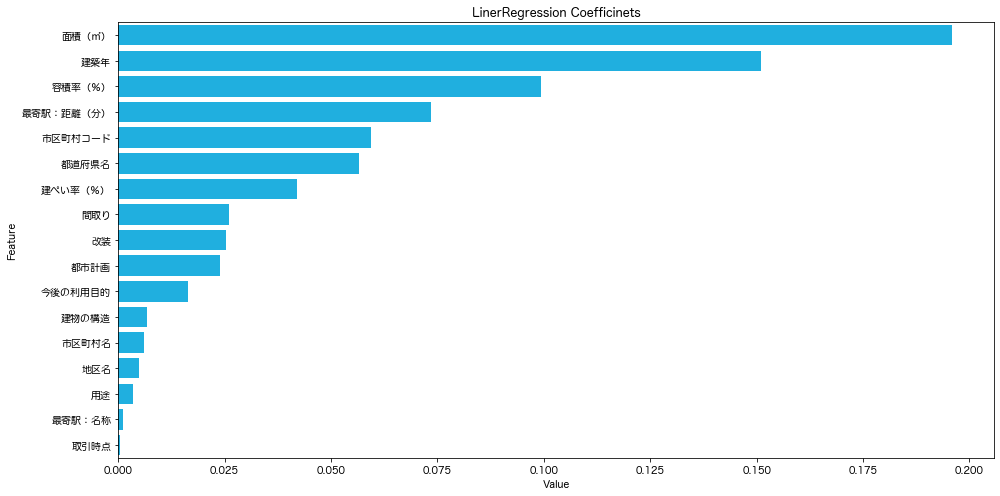

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(np.abs(lr.coef_),X_train.columns)), columns=['Value','Feature'])
plt.figure(figsize=(14, 7))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False), color= "deepskyblue")
plt.title('LinerRegression Coefficinets')
plt.tight_layout()
plt.show()

### 検証データに対して推論結果を算出

In [ ]:
val_pred = lr.predict(X_val)
mean_absolute_error(y_val, val_pred)

0.17553636223427777

### submission.csvの生成

In [ ]:
# Test.csvのデータに対して推論を行いsubmission.csvで記載のフォーマットに合わせます
test_df[TARGET_COL] = lr.predict(test_df.drop("ID", axis=1))

submission = pd.read_csv(SUBMISSION_DIR)
submission["取引価格（総額）_log"] = test_df[TARGET_COL]
submission = pd.merge(submission["ID"], test_df[["ID",TARGET_COL]], on="ID")

In [ ]:
submission

,ID,取引価格（総額）_log
0,1000000,7.188772
1,1000056,7.704291
2,1000108,6.869441
3,1000109,7.204846
4,1000110,6.769197
...,...,...
19461,47003828,7.578019
19462,47003829,7.286010
19463,47003880,7.040516
19464,47006648,7.332219


In [ ]:
# 名前をつけてcsvに保存します
'''
データ分析コンペでは予測結果を繰り返し作成するので訓練したモデルの名称とタイムスタンプをcsvの名前につけると後で管理がしやすいです。
'''
exp_name = "linerregression_baseline"

import pytz
import datetime
now = datetime.datetime.now(pytz.timezone('Asia/Tokyo')).strftime('%Y-%m-%d-%H-%M-%S')
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

submission.to_csv(f"{OUTPUT_DIR}submission_{exp_name}_{now}.csv", index=False)